<a href="https://colab.research.google.com/github/Vinaytandle/API-for-Product-Review/blob/main/Vinay_Tandle_Assighnment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
from google.colab import files

# Upload files
uploaded = files.upload()

# Load datasets
customers_df = pd.read_csv("Customers.csv")
products_df = pd.read_csv("Products.csv")
transactions_df = pd.read_csv("Transactions.csv")

# Preview data
print(customers_df.head())
print(products_df.head())
print(transactions_df.head())


Saving Transactions.csv to Transactions.csv
Saving Products.csv to Products.csv
Saving Customers.csv to Customers.csv
  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      

In [4]:
# Convert date columns to datetime
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])

# Merge datasets
merged_df = transactions_df.merge(customers_df, on="CustomerID", how="left")
merged_df = merged_df.merge(products_df, on="ProductID", how="left")


In [5]:
# EDA
print("Total Customers:", customers_df['CustomerID'].nunique())
print("Total Products:", products_df['ProductID'].nunique())
print("Total Transactions:", transactions_df['TransactionID'].nunique())

# Regional Distribution
print(customers_df['Region'].value_counts())

# Top-Selling Categories
top_categories = merged_df.groupby('Category')['Quantity'].sum().sort_values(ascending=False)
print(top_categories)

# Monthly Sales
monthly_sales = merged_df.resample('M', on='TransactionDate')['TotalValue'].sum()
print(monthly_sales)


Total Customers: 200
Total Products: 100
Total Transactions: 1000
Region
South America    59
Europe           50
North America    46
Asia             45
Name: count, dtype: int64
Category
Books          681
Home Decor     639
Electronics    627
Clothing       590
Name: Quantity, dtype: int64
TransactionDate
2023-12-31     3769.52
2024-01-31    66376.39
2024-02-29    51459.27
2024-03-31    47828.73
2024-04-30    57519.06
2024-05-31    64527.74
2024-06-30    48771.18
2024-07-31    71366.39
2024-08-31    63436.74
2024-09-30    70603.75
2024-10-31    47063.22
2024-11-30    38224.37
2024-12-31    59049.20
Freq: ME, Name: TotalValue, dtype: float64


<ipython-input-5-a4fb5ede2fae>:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = merged_df.resample('M', on='TransactionDate')['TotalValue'].sum()


In [6]:
# Create a text feature for each customer summarizing their transactions
merged_df['TransactionSummary'] = merged_df['ProductName'] + " " + merged_df['Category']
customer_summary = merged_df.groupby('CustomerID')['TransactionSummary'].apply(' '.join).reset_index()


In [7]:
# TF-IDF Vectorization
tfidf = TfidfVectorizer()
customer_vectors = tfidf.fit_transform(customer_summary['TransactionSummary'])

# Compute similarity matrix
similarity_matrix = cosine_similarity(customer_vectors)

# Function to find top 3 similar customers
def get_top_3_similar(customers, similarity_matrix, idx):
    scores = similarity_matrix[idx]
    similar_indices = scores.argsort()[-4:-1][::-1]  # Top 3 (excluding self)
    similar_scores = scores[similar_indices]
    similar_customers = customers.iloc[similar_indices]['CustomerID'].values
    return list(zip(similar_customers, similar_scores))

# Generate Lookalikes for first 20 customers
lookalike_results = {}
customers_list = customer_summary.reset_index()
for idx in range(20):  # CustomerID: C0001 - C0020
    cust_id = customers_list.iloc[idx]['CustomerID']
    lookalike_results[cust_id] = get_top_3_similar(customers_list, similarity_matrix, idx)

# Save Lookalike results
lookalike_df = pd.DataFrame({
    "CustomerID": lookalike_results.keys(),
    "Lookalikes": [str(val) for val in lookalike_results.values()]
})
lookalike_df.to_csv("Lookalike.csv", index=False)
print("Lookalike model completed. File saved as Lookalike.csv.")


Lookalike model completed. File saved as Lookalike.csv.


In [8]:
# Aggregate customer-level data
clustering_data = merged_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'Quantity': 'sum',    # Total quantity purchased
    'TransactionID': 'count'  # Number of transactions
}).rename(columns={'TransactionID': 'Frequency'}).reset_index()

# Normalize data
scaler = StandardScaler()
clustering_scaled = scaler.fit_transform(clustering_data[['TotalValue', 'Quantity', 'Frequency']])


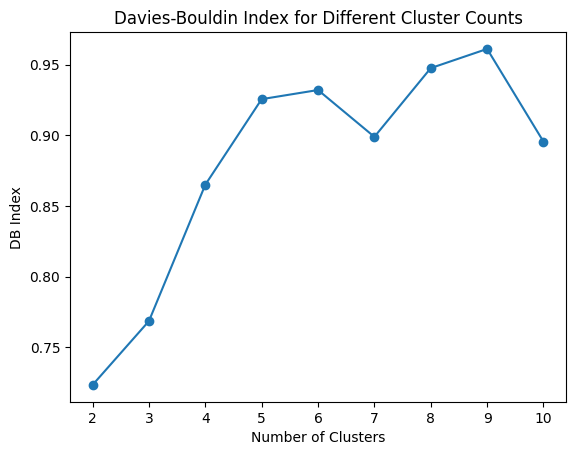

Optimal Number of Clusters: 2


In [9]:
# Test clustering with 2-10 clusters
db_scores = []
cluster_range = range(2, 11)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(clustering_scaled)
    db_index = davies_bouldin_score(clustering_scaled, clusters)
    db_scores.append(db_index)

# Plot DB index scores
plt.plot(cluster_range, db_scores, marker='o')
plt.title('Davies-Bouldin Index for Different Cluster Counts')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.show()

# Optimal number of clusters
optimal_k = cluster_range[np.argmin(db_scores)]
print(f"Optimal Number of Clusters: {optimal_k}")


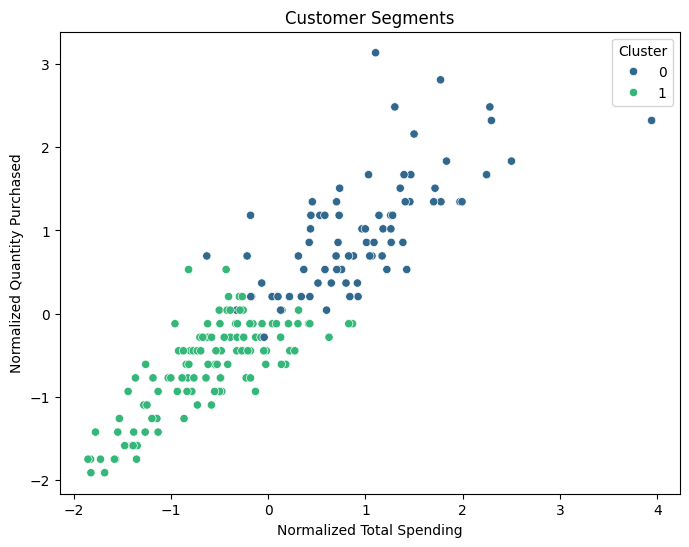

Clustering completed. File saved as Customer_Segments.csv.


In [10]:
# Final clustering
final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clustering_data['Cluster'] = final_kmeans.fit_predict(clustering_scaled)

# Visualize clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x=clustering_scaled[:, 0], y=clustering_scaled[:, 1], hue=clustering_data['Cluster'], palette='viridis')
plt.title('Customer Segments')
plt.xlabel('Normalized Total Spending')
plt.ylabel('Normalized Quantity Purchased')
plt.legend(title='Cluster')
plt.show()

# Save clustering results
clustering_data.to_csv("Customer_Segments.csv", index=False)
print("Clustering completed. File saved as Customer_Segments.csv.")


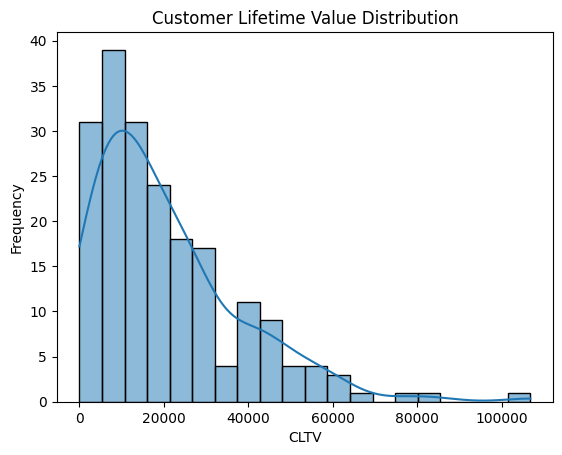

Top 10 High CLTV Customers:
    CustomerID       CLTV
140      C0141  106738.70
155      C0156   83978.95
64       C0065   76637.00
53       C0054   64323.12
174      C0175   62105.30
164      C0165   60372.90
108      C0109   60359.75
186      C0188   56890.56
58       C0059   56586.24
27       C0028   54556.56


In [12]:
# CLTV Calculation
clustering_data['CLTV'] = clustering_data['TotalValue'] * clustering_data['Frequency']

# Segment Customers Based on CLTV
clustering_data['CLTV_Segment'] = pd.qcut(clustering_data['CLTV'], q=3, labels=['Low', 'Medium', 'High'])

# Visualize CLTV Distribution
sns.histplot(clustering_data['CLTV'], kde=True, bins=20)
plt.title('Customer Lifetime Value Distribution')
plt.xlabel('CLTV')
plt.ylabel('Frequency')
plt.show()

# Top 10 Customers by CLTV
top_cltv = clustering_data[['CustomerID', 'CLTV']].sort_values(by='CLTV', ascending=False).head(10)
print("Top 10 High CLTV Customers:")
print(top_cltv)


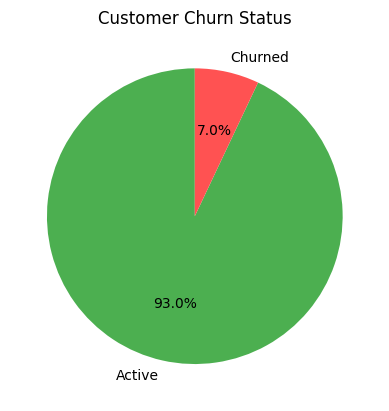

In [13]:
# Define Churn Threshold (e.g., no transaction in the last 180 days)
latest_date = merged_df['TransactionDate'].max()
merged_df['DaysSinceLastPurchase'] = (latest_date - merged_df['TransactionDate']).dt.days

# Mark customers as "Churned" or "Active"
clustering_data['Churned'] = clustering_data['CustomerID'].apply(
    lambda x: merged_df[merged_df['CustomerID'] == x]['DaysSinceLastPurchase'].max() > 180
)

# Churned vs Active Visualization
churn_summary = clustering_data['Churned'].value_counts()
plt.pie(churn_summary, labels=['Active', 'Churned'], autopct='%1.1f%%', startangle=90, colors=['#4CAF50', '#FF5252'])
plt.title('Customer Churn Status')
plt.show()


Top 20% Products Contributing to 80% Revenue:
ProductName
ActiveWear Smartwatch         0.056663
SoundWave Headphones          0.093201
SoundWave Novel               0.128720
ActiveWear Jacket             0.161637
ActiveWear Rug                0.193977
TechPro Headphones            0.222258
BookWorld Cookbook            0.250117
BookWorld Sweater             0.277282
TechPro Textbook              0.303757
ActiveWear Cookware Set       0.329966
SoundWave Desk Lamp           0.355937
TechPro Cookbook              0.381887
ActiveWear Textbook           0.406898
HomeSense Desk Lamp           0.429654
SoundWave Cookbook            0.451542
BookWorld Biography           0.473398
HomeSense Novel               0.494546
TechPro T-Shirt               0.515219
ActiveWear Headphones         0.535448
SoundWave Jeans               0.555662
TechPro Smartwatch            0.575631
ComfortLiving Sweater         0.595179
ComfortLiving Smartphone      0.614356
HomeSense Cookware Set        0.631861
Active

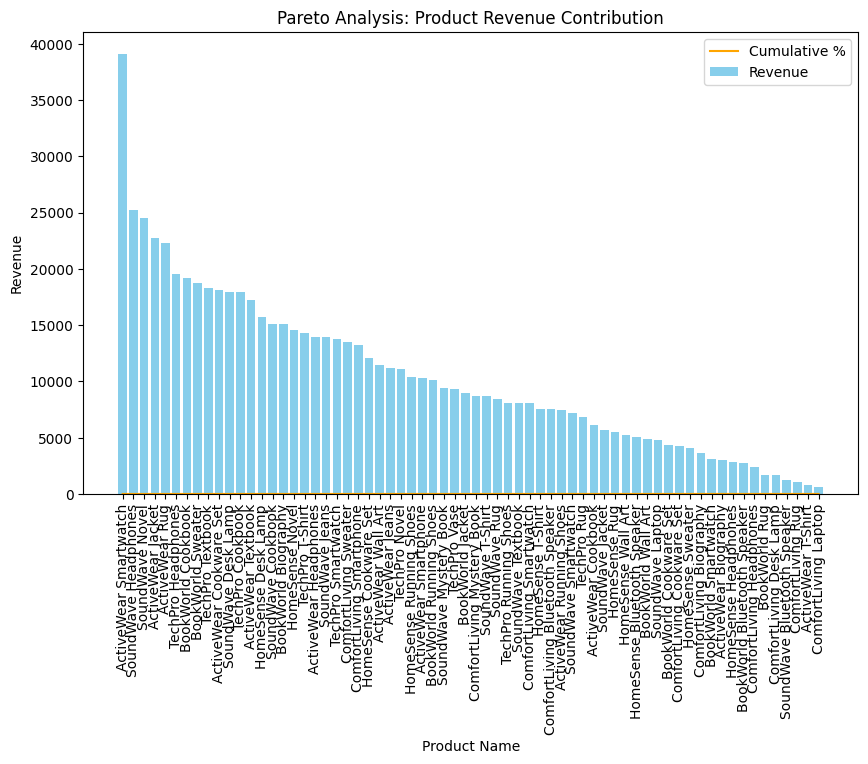

In [14]:
# Calculate Total Revenue per Product
product_revenue = merged_df.groupby('ProductName')['TotalValue'].sum().sort_values(ascending=False)

# Cumulative Contribution
product_revenue_cumsum = product_revenue.cumsum() / product_revenue.sum()

# Find 20% of Products Contributing 80% of Revenue
top_20_percent = product_revenue_cumsum[product_revenue_cumsum <= 0.8]
print(f"Top 20% Products Contributing to 80% Revenue:\n{top_20_percent}")

# Pareto Chart
plt.figure(figsize=(10, 6))
plt.bar(product_revenue.index, product_revenue, color='skyblue', label='Revenue')
plt.plot(product_revenue.index, product_revenue_cumsum, color='orange', label='Cumulative %')
plt.xticks(rotation=90)
plt.title('Pareto Analysis: Product Revenue Contribution')
plt.xlabel('Product Name')
plt.ylabel('Revenue')
plt.legend()
plt.show()


In [15]:
# Cluster Centers
cluster_centers = pd.DataFrame(final_kmeans.cluster_centers_, columns=['TotalValue', 'Quantity', 'Frequency'])

# Add CLTV Interpretation to Clusters
cluster_centers['Average_CLTV'] = cluster_centers['TotalValue'] * cluster_centers['Frequency']

print("Cluster Centers with Interpretations:")
print(cluster_centers)

# Assign Cluster Labels (e.g., High Spenders, Occasional Buyers)
cluster_labels = ['High Spenders', 'Frequent Buyers', 'Low Spenders', 'Moderate Buyers']
cluster_centers['Cluster_Label'] = cluster_labels[:len(cluster_centers)]
print(cluster_centers)


Cluster Centers with Interpretations:
   TotalValue  Quantity  Frequency  Average_CLTV
0    0.923619  0.973465   0.952567      0.879809
1   -0.608049 -0.640864  -0.627107      0.381312
   TotalValue  Quantity  Frequency  Average_CLTV    Cluster_Label
0    0.923619  0.973465   0.952567      0.879809    High Spenders
1   -0.608049 -0.640864  -0.627107      0.381312  Frequent Buyers


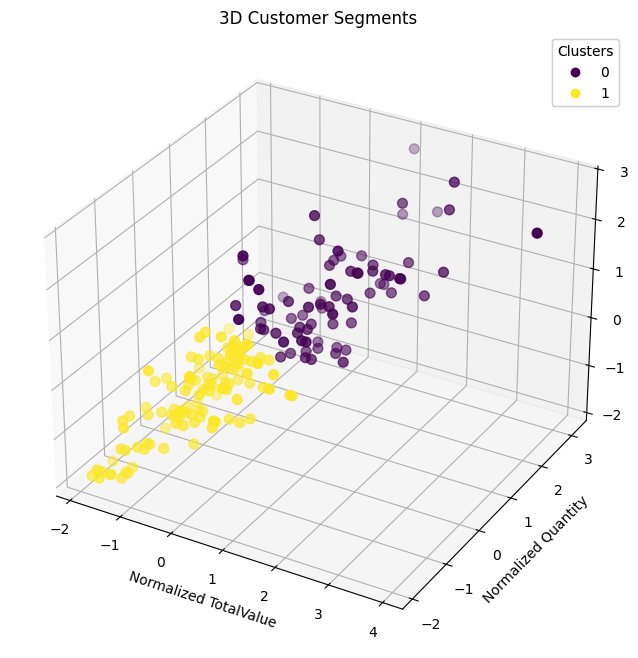

In [16]:
from mpl_toolkits.mplot3d import Axes3D

# 3D Scatter Plot of Clusters
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for clusters
scatter = ax.scatter(
    clustering_scaled[:, 0], clustering_scaled[:, 1], clustering_scaled[:, 2],
    c=clustering_data['Cluster'], cmap='viridis', s=50
)

# Add labels and legend
ax.set_title('3D Customer Segments')
ax.set_xlabel('Normalized TotalValue')
ax.set_ylabel('Normalized Quantity')
ax.set_zlabel('Normalized Frequency')
legend = ax.legend(*scatter.legend_elements(), title='Clusters')
ax.add_artist(legend)
plt.show()


In [45]:
# This code will generate the EDA PDF file directly from Colab

# Install necessary libraries (only if not installed)
!pip install nbconvert
!apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

# Import required libraries
import os
from google.colab import files

# Save the notebook as an .ipynb file
notebook_name = 'FirstName_LastName_EDA.ipynb'  # Set your notebook name here
!jupyter nbconvert --to notebook --execute {notebook_name}  # Execute the notebook to ensure it is up-to-date

# Convert the notebook into PDF
!jupyter nbconvert --to pdf {notebook_name}

# The PDF file will be generated and saved as 'FirstName_LastName_EDA.pdf'
# Now, download the PDF file
files.download('FirstName_LastName_EDA.pdf')  # This will trigger the download of the PDF file


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package texlive-generic-recommended
[NbConvertApp] WARNING | pattern 'FirstName_LastName_EDA.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equival

FileNotFoundError: Cannot find file: FirstName_LastName_EDA.pdf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package texlive-generic-recommended
Davies-Bouldin Index: 0.3420157228543302


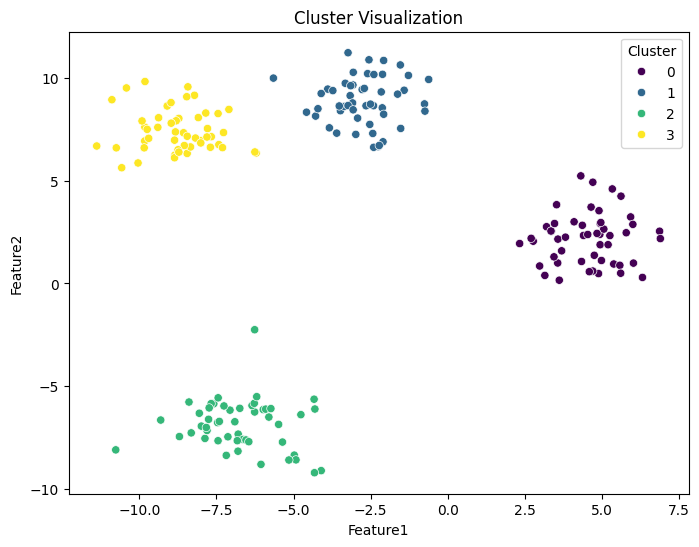

[NbConvertApp] WARNING | pattern 'FirstName_LastName_Clustering.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=T

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [47]:
# Install necessary libraries (if not already installed)
!pip install nbconvert
!apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended
!pip install scikit-learn matplotlib pandas seaborn

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset (replace 'your_dataset.csv' with your actual dataset file)
# For this example, I'll generate a synthetic dataset for clustering
from sklearn.datasets import make_blobs
X, _ = make_blobs(n_samples=200, centers=4, cluster_std=1.2, random_state=42)
df = pd.DataFrame(X, columns=['Feature1', 'Feature2'])

# Perform KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(df[['Feature1', 'Feature2']])

# Calculate the Davies-Bouldin Index (DB Index)
db_index = davies_bouldin_score(df[['Feature1', 'Feature2']], df['Cluster'])
print(f"Davies-Bouldin Index: {db_index}")

# Visualize Clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Feature1', y='Feature2', hue='Cluster', palette='viridis')
plt.title('Cluster Visualization')
plt.savefig('clustering_plot.png')  # Save the cluster plot
plt.show()

# Save clustering results to a CSV file
df[['Feature1', 'Feature2', 'Cluster']].to_csv('Clustering_Results.csv', index=False)

# Export Notebook as a PDF File
notebook_name = 'FirstName_LastName_Clustering.ipynb'  # Replace with your actual notebook name

# Save the notebook with execution
!jupyter nbconvert --to notebook --execute {notebook_name}

# Convert the notebook into a PDF
!jupyter nbconvert --to pdf {notebook_name}

# Download the Clustering Results and PDF File
from google.colab import files
files.download('Clustering_Results.csv')  # Download the clustering results
 # Download the clustering PDF file
